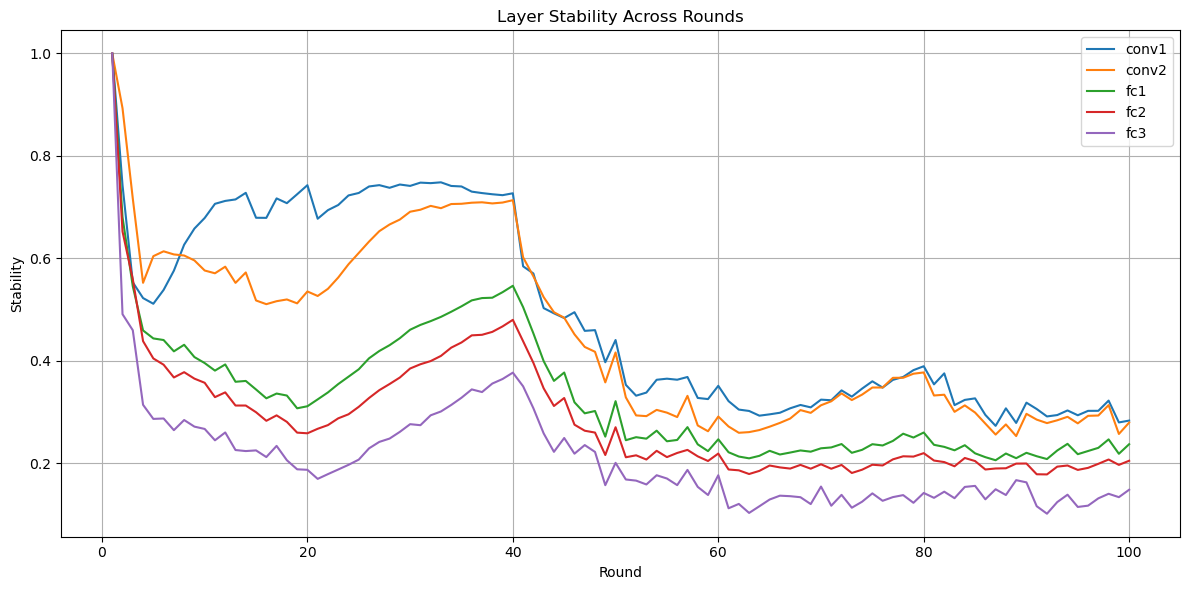

In [8]:
import re, ast, pandas as pd
import matplotlib.pyplot as plt

log_path = "log.txt"
data = []
current_round = None

with open(log_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

i = 0
while i < len(lines):
    line = lines[i]

    round_match = re.search(r"--- Starting Round (\d+)", line)
    if round_match:
        current_round = int(round_match.group(1))

    if "Calculated Layer Stabilities:" in line:
        # Start capturing the dictionary across possibly multiple lines
        dict_lines = [line.split("Calculated Layer Stabilities:")[1]]
        i += 1
        while i < len(lines) and "}" not in dict_lines[-1]:
            dict_lines.append(lines[i])
            i += 1
        dict_str = "".join(dict_lines).strip()
        try:
            stabilities = ast.literal_eval(dict_str)
            stabilities_float = {k: float(v) for k, v in stabilities.items()}
            stabilities_float["round"] = current_round
            data.append(stabilities_float)
        except Exception as e:
            print(f"Error parsing stability dict near round {current_round}: {e}")
            # print(dict_str)
            pass
        continue  # skip increment at bottom since we already moved index when collecting

    i += 1

# Convert to DataFrame
df = pd.DataFrame(data).sort_values("round")

# Ensure 'round' is present
if 'round' in df.columns:
    # Plot stabilities for each layer
    plt.figure(figsize=(12, 6))
    for layer in sorted([col for col in df.columns if col != "round"]):
        plt.plot(df["round"], df[layer], label=layer)
    plt.xlabel("Round")
    plt.ylabel("Stability")
    plt.title("Layer Stability Across Rounds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No stability data found.")


#Baseline p/ comparação

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset
import random
import csv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Dados com concept drift Não-IID (mesma função do seu código original) ---
def create_dynamic_non_iid_data(dataset, num_clients=100, alpha_sequence=[0.3, 1.0, 0.1], drift_intervals=[50, 100, 200]):
    if not alpha_sequence:
        alpha_sequence = [1.0]
        drift_intervals = []

    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))

    extended_drift_intervals = []
    if drift_intervals:
        max_initial_drift_interval = drift_intervals[-1]
        num_drift_epochs = 10
        for i in range(num_drift_epochs):
            extended_drift_intervals.extend([interval + i * max_initial_drift_interval for interval in drift_intervals])
    else:
        extended_drift_intervals = [float('inf')]

    data_by_phase = []
    for phase_idx, alpha_val in enumerate(alpha_sequence):
        client_data_indices = [[] for _ in range(num_clients)]
        class_indices = [np.where(targets == i)[0] for i in range(num_classes)]

        for c in range(num_classes):
            dirichlet_alpha = alpha_val if isinstance(alpha_val, (int, float)) else alpha_val[c % len(alpha_val)]
            effective_dirichlet_alpha = max(dirichlet_alpha, 1e-4) * np.ones(num_clients)
            proportions = np.random.dirichlet(effective_dirichlet_alpha)
            num_samples_in_class = len(class_indices[c])
            proportions_samples = (proportions * num_samples_in_class).astype(float)
            proportions_int = np.floor(proportions_samples).astype(int)
            remainder = proportions_samples - proportions_int
            deficit = num_samples_in_class - proportions_int.sum()

            if deficit < 0:
                indices_to_reduce = np.argsort(proportions_int)[::-1]
                for i in range(abs(deficit)):
                    proportions_int[indices_to_reduce[i % num_clients]] -= 1
                proportions_int = np.maximum(0, proportions_int)
                deficit = 0

            indices_sorted_by_remainder = np.argsort(remainder)[::-1]
            for i in range(deficit):
                proportions_int[indices_sorted_by_remainder[i % num_clients]] += 1

            if proportions_int.sum() != num_samples_in_class:
                final_diff = num_samples_in_class - proportions_int.sum()
                for i in range(abs(final_diff)):
                    proportions_int[i % num_clients] += np.sign(final_diff)
                proportions_int = np.maximum(0, proportions_int)

            indices = np.array(class_indices[c])
            np.random.shuffle(indices)
            current_sum = 0
            splits = []
            for p_val in proportions_int:
                splits.append(indices[current_sum : current_sum + p_val])
                current_sum += p_val

            for i, client_idx_list in enumerate(client_data_indices):
                if i < len(splits):
                    client_idx_list.extend(splits[i])
        data_by_phase.append(client_data_indices)

    def get_client_data_for_round(round_num):
        phase = 0
        if extended_drift_intervals and extended_drift_intervals[0] != float('inf'):
            phase = sum([round_num >= interval for interval in extended_drift_intervals]) % len(alpha_sequence)

        client_loaders = {}
        if phase >= len(data_by_phase):
            phase = 0
        current_phase_data_indices = data_by_phase[phase]

        for client_id, indices in enumerate(current_phase_data_indices):
            valid_indices = [idx for idx in indices if isinstance(idx, (int, np.integer))]
            if len(valid_indices) > 0:
                subset = Subset(dataset, valid_indices)
                if len(subset) == 0: continue
                batch_size = min(50, len(subset))
                if batch_size > 0:
                    client_loaders[client_id] = DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=0)
        return client_loaders, phase
    return get_client_data_for_round

# --- 2. Modelo CNN Simples ---
class CNN5(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 3. Funções auxiliares ---
def train_client(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    if total_samples == 0:
        return 0.0
    return total_loss / total_samples

def aggregate_models(global_model, client_models):
    if not client_models:
        return
    global_state = global_model.state_dict()
    client_states = [client.state_dict() for client in client_models]
    for key in global_state.keys():
        if all(key in state for state in client_states):
            if client_states[0][key].dtype in [torch.float32, torch.float16, torch.float64]:
                global_state[key] = torch.stack(
                    [state[key].float() for state in client_states], dim=0
                ).mean(dim=0).to(global_state[key].dtype)
            else:
                global_state[key] = client_states[0][key]
    global_model.load_state_dict(global_state)

def evaluate_model(model, dataloader, criterion, device='cpu'):
    model.eval()
    correct, total, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            total_loss += loss.item() * inputs.size(0)
    if total == 0:
        return 0.0, 0.0
    return 100.0 * correct / total, total_loss / total

# --- 4. Parâmetros ---
NUM_CLIENTS = 100
NUM_ROUNDS = 100 
PARTICIPATION_RATE = 0.1
BATCH_SIZE = 50
LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
ALPHA_SEQUENCE = [0.3, 10.0, 0.1, 1.0, 0.2]
DRIFT_INTERVALS = [20, 40, 60, 80]

print("Preparing data...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform_test)
get_client_data_loaders_for_round = create_dynamic_non_iid_data(
    train_dataset, NUM_CLIENTS, ALPHA_SEQUENCE, DRIFT_INTERVALS
)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)
print("Data preparation finished.")

print("Initializing model...")
global_model = CNN5(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()

num_participants = int(NUM_CLIENTS * PARTICIPATION_RATE)
active_phase = -1

print("Starting Federated Learning Loop (baseline, no freezing)...")
log_records = []

for rnd in range(NUM_ROUNDS):
    current_round_num = rnd + 1
    print(f"\n--- Starting Round {current_round_num}/{NUM_ROUNDS} ---")

    client_data_map, current_phase = get_client_data_loaders_for_round(rnd)
    if active_phase != current_phase:
        print(f"** Concept Drift: Switched to Alpha Phase {current_phase} (Alpha={ALPHA_SEQUENCE[current_phase]}) **")
        active_phase = current_phase

    if not client_data_map:
        print(f"Warning: No client data for round {current_round_num}. Skipping.")
        continue

    available_clients_with_data = list(client_data_map.keys())
    if not available_clients_with_data:
        print(f"Warning: No clients with data loaders for round {current_round_num}. Skipping.")
        continue

    actual_participants_count = min(num_participants, len(available_clients_with_data))
    if actual_participants_count == 0:
        print(f"Warning: Not enough participants for round {current_round_num}. Skipping.")
        continue

    selected_clients_ids = random.sample(available_clients_with_data, actual_participants_count)
    print(f"[Round {current_round_num}] Selected {len(selected_clients_ids)} clients for training.")

    client_models, local_losses = [], []

    for client_id in selected_clients_ids:
        local_model = CNN5(num_classes=10).to(device)
        local_model.load_state_dict(global_model.state_dict())

        # Todos os parâmetros treináveis, sem congelamento
        for param in local_model.parameters():
            param.requires_grad = True

        optimizer = optim.SGD(local_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

        local_loss = train_client(local_model, client_data_map[client_id], optimizer, criterion, device=device)
        local_losses.append(local_loss)
        client_models.append(local_model)

    if client_models:
        print(f"[Round {current_round_num}] Aggregating {len(client_models)} client models...")
        aggregate_models(global_model, client_models)
    else:
        print(f"[Round {current_round_num}] No client models to aggregate.")

    test_acc, test_loss = evaluate_model(global_model, test_loader, criterion, device)
    print(f"[Round {current_round_num}] EVAL - Test Acc: {test_acc:.2f}%, Test Loss: {test_loss:.4f}")

    avg_train_loss = sum(local_losses) / len(local_losses) if local_losses else 0.0
    log_records.append([current_round_num, avg_train_loss, test_loss, test_acc])

log_filename = "federated_log_baseline_no_freezing.csv"
print(f"\nTraining finished. Saving logs to {log_filename}...")
try:
    with open(log_filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Round", "AvgTrainLoss", "TestLoss", "TestAccuracy"])
        for row in log_records:
            writer.writerow(row)
    print("Logs saved successfully.")
except Exception as e:
    print(f"Error saving logs: {e}")

print("===== Baseline Experiment Finished =====")


Using device: cpu
Preparing data...
Files already downloaded and verified
Files already downloaded and verified
Data preparation finished.
Initializing model...
Starting Federated Learning Loop (baseline, no freezing)...

--- Starting Round 1/100 ---
** Concept Drift: Switched to Alpha Phase 0 (Alpha=0.3) **
[Round 1] Selected 10 clients for training.
[Round 1] Aggregating 10 client models...
[Round 1] EVAL - Test Acc: 14.12%, Test Loss: 2.3116

--- Starting Round 2/100 ---
[Round 2] Selected 10 clients for training.
[Round 2] Aggregating 10 client models...
[Round 2] EVAL - Test Acc: 11.12%, Test Loss: 2.3027

--- Starting Round 3/100 ---
[Round 3] Selected 10 clients for training.
[Round 3] Aggregating 10 client models...
[Round 3] EVAL - Test Acc: 18.11%, Test Loss: 2.3191

--- Starting Round 4/100 ---
[Round 4] Selected 10 clients for training.
[Round 4] Aggregating 10 client models...
[Round 4] EVAL - Test Acc: 15.00%, Test Loss: 2.2857

--- Starting Round 5/100 ---
[Round 5] Sele

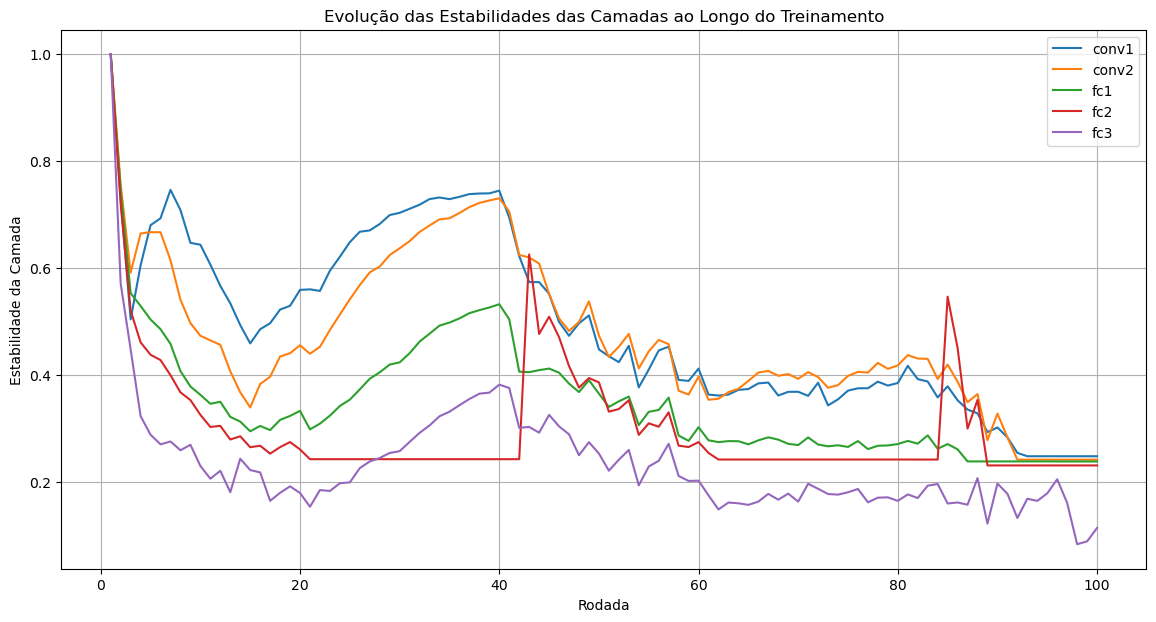

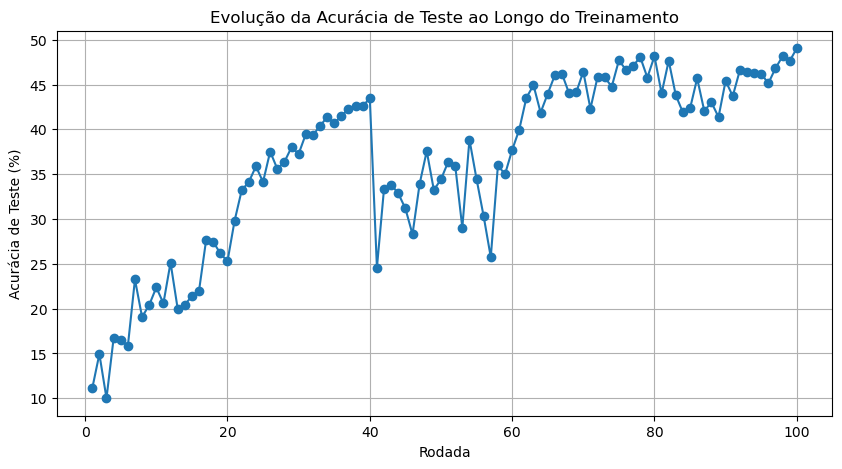

In [ ]:
#LOG2.TXT PLOT

import re
import matplotlib.pyplot as plt

log_file = 'log3.txt'

rounds = []
stabilities = {
    'conv1': [],
    'conv2': [],
    'fc1': [],
    'fc2': [],
    'fc3': []
}
accuracies = []

round_pattern = re.compile(r'--- Starting Round (\d+)/100 ---')
stability_pattern = re.compile(r'Calculated Layer Stabilities: \{([^}]+)\}')
accuracy_pattern = re.compile(r'\[Round \d+\] EVAL - Test Acc: ([\d\.]+)%')

with open(log_file, 'r') as f:
    content = f.read()

round_matches = list(round_pattern.finditer(content))

for i, match in enumerate(round_matches):
    round_num = int(match.group(1))
    rounds.append(round_num)
    
    start_idx = match.end()
    end_idx = round_matches[i + 1].start() if i + 1 < len(round_matches) else len(content)
    round_text = content[start_idx:end_idx]
    
    # Extrair as estabilidades da camada com regex, capturando pares camada: valor
    stab_match = stability_pattern.search(round_text)
    if stab_match:
        stab_str = stab_match.group(1)  # string no formato: 'conv1': '0.9998', 'conv2': '0.9998', ...
        # Para cada camada, buscar valor float dentro da string:
        for layer in stabilities.keys():
            layer_pattern = re.compile(r"'" + layer + r"': '([\d\.]+)'")
            m = layer_pattern.search(stab_str)
            if m:
                val = float(m.group(1))
            else:
                val = float('nan')
            stabilities[layer].append(val)
    else:
        for layer in stabilities.keys():
            stabilities[layer].append(float('nan'))
    
    acc_match = accuracy_pattern.search(round_text)
    if acc_match:
        acc = float(acc_match.group(1))
        accuracies.append(acc)
    else:
        accuracies.append(float('nan'))

# Plotar estabilidades
plt.figure(figsize=(14, 7))
for layer, values in stabilities.items():
    plt.plot(rounds, values, label=layer)
plt.xlabel('Rodada')
plt.ylabel('Estabilidade da Camada')
plt.title('Evolução das Estabilidades das Camadas ao Longo do Treinamento')
plt.legend()
plt.grid(True)
plt.show()

# Plotar acurácia
plt.figure(figsize=(10, 5))
plt.plot(rounds, accuracies, marker='o')
plt.xlabel('Rodada')
plt.ylabel('Acurácia de Teste (%)')
plt.title('Evolução da Acurácia de Teste ao Longo do Treinamento')
plt.grid(True)
plt.show()


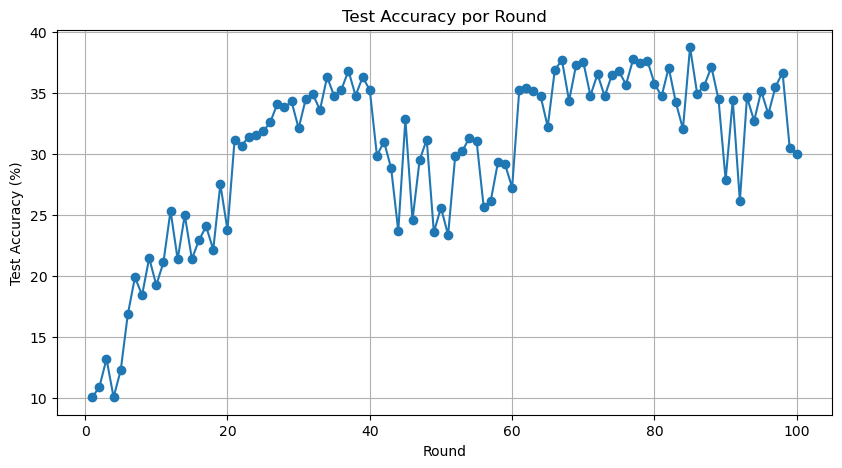

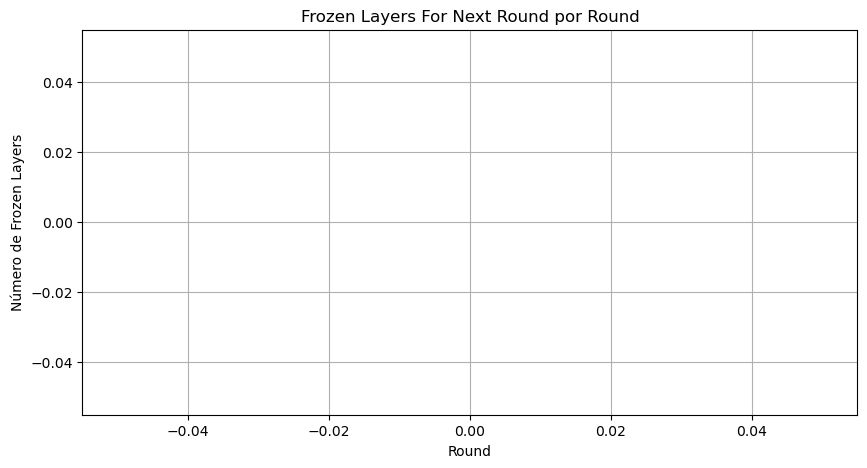

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# Carregar o CSV enviado
file_path = 'federated_log_proactiveOFF_FT_0.25_UT_0.35_KP_3.csv'
df = pd.read_csv(file_path)

# Mostrar as primeiras linhas e colunas para ver a estrutura dos dados
df.head(), df.columns.tolist()

# Converter a coluna FrozenLayersForNextRound para numérica, tratando 'None' como NaN
df['FrozenLayersForNextRound'] = pd.to_numeric(df['FrozenLayersForNextRound'], errors='coerce')

# Plotar TestAccuracy vs Round
plt.figure(figsize=(10, 5))
plt.plot(df['Round'], df['TestAccuracy'], marker='o')
plt.title('Test Accuracy por Round')
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.show()

# Plotar FrozenLayersForNextRound vs Round
plt.figure(figsize=(10, 5))
plt.plot(df['Round'], df['FrozenLayersForNextRound'], marker='o', color='orange')
plt.title('Frozen Layers For Next Round por Round')
plt.xlabel('Round')
plt.ylabel('Número de Frozen Layers')
plt.grid(True)
plt.show()

